In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline
acc_round_val = 2
f1_round_val = 4

# Set the task
task_name = 'maptask'
# Get Maptask metadata and training set
base_url = 'https://raw.github.com/NathanDuran/Maptask-Corpus/master/maptask_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing.
Less frequent words were considered OOV and replaced with the <unk> token. Increments of 100 in the range [100, 1600].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std', 'f1_weighted']]) ###TODO keep weighted?
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val, 'f1_weighted':f1_round_val})

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
83        gru        1200  58.872602     0.237911
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_micro  f1_micro_std  f1_weighted
87        gru         800  60.815372      0.828933  0.608617      0.007864     0.596317


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,500,57.85,0.18,700,59.45,0.35,0.5948,0.0038
1,text cnn,200,56.60,0.33,1100,59.36,0.68,0.5939,0.0066
2,dcnn,600,56.08,0.32,500,59.24,0.45,0.5930,0.0044
3,rcnn,1100,58.28,0.20,800,60.28,0.44,0.6032,0.0045
4,lstm,800,55.88,0.38,900,60.37,0.52,0.6040,0.0050
5,gru,1200,58.87,0.24,800,60.82,0.83,0.6086,0.0079


Plot accuracy of each model per vocabulary size.

Vertical lines are the mean frequency of word occurrence within a given range
i.e. the 200-300 most frequent words appear, on average, ~71 times.

    vocab_size    mean_freq   cum_sum
0        100.0  1268.712871  128140.0
1        200.0   162.356436  144259.0
2        300.0    71.693069  151403.0
3        400.0    45.188119  155911.0
4        500.0    28.287129  158733.0
5        600.0    19.000000  160629.0
6        700.0    12.326733  161859.0
7        800.0     7.752475  162632.0
8        900.0     5.128713  163144.0
9       1000.0     3.415842  163485.0
10      1100.0     2.554455  163740.0
11      1200.0     2.000000  163940.0
12      1300.0     1.267327  164066.0
13      1400.0     1.000000  164166.0
14      1500.0     1.000000  164266.0
15      1600.0     1.000000  164365.0
Total word count: 164562
Percentage of words for vocabulary size 400: 94.74


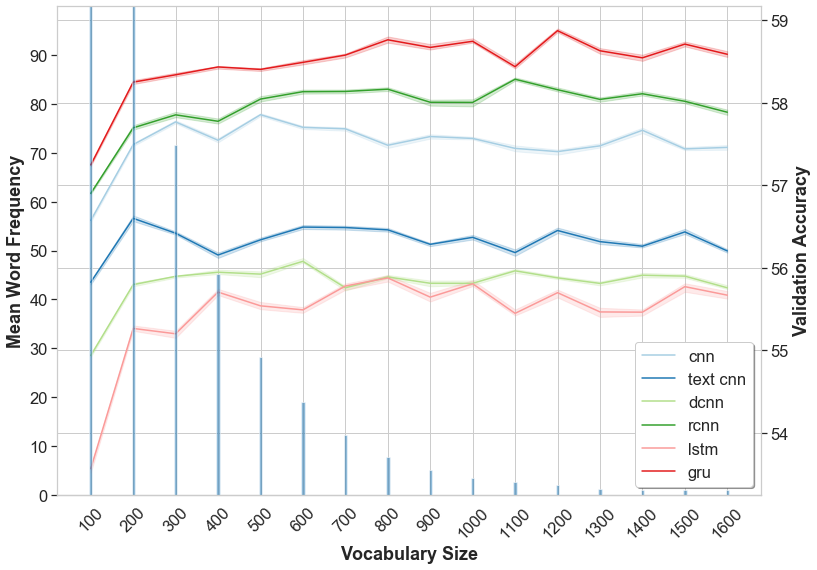

In [3]:
# Get word frequencies from metadata and bin/sum into same values as experiment
word_freq = metadata['word_freq'].iloc[:1600]
words_frame = pd.DataFrame(columns=['vocab_size', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 100
for i in range(16):
    words_frame = words_frame.append({'vocab_size': ind_end,
                        'mean_freq': float(word_freq.loc[ind_start:ind_end].mean()), # Binning
                        'cum_sum': word_freq.loc[0:ind_end].sum()['Count']}, # Cumulative summing
                       ignore_index=True)
    ind_start += 100
    ind_end += 100
print(words_frame)

# Calculate percentage of words up to specified vocabulary size
vocab_size = 400
total_words = metadata['word_freq']['Count'].sum()
word_cum_sum = float(words_frame.loc[(words_frame['vocab_size'] == vocab_size)]['cum_sum'])
perc_of_total = (100 / total_words) * word_cum_sum
print("Total word count: " + str(total_words))
print("Percentage of words for vocabulary size " + str(vocab_size) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, words_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='mean_freq', bar_axis_step=10, bar_axis_range=[0, 100], bar_width=8,
                          bar_y_label='Mean Word Frequency', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1, xtick_rotation=45)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different vocabulary size groups.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

All models vocab_size are normally distributed.
All models vocab_size have equal variance.
All models have significant p-values when comparing vocab_size groups.


c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq,cohen_f,n,exp_n,power,exp_power
cnn,11.8871,15,0.792476,11.5473,3.7415e-18,0.546042,0.497188,1.08256,160,32.1958,1,0.8
text cnn,5.06137,15,0.337425,3.90458,7.43509e-06,0.28913,0.214025,0.366054,160,64.9024,0.999758,0.8
dcnn,9.31015,15,0.620677,8.47797,1.14676e-13,0.468967,0.412131,0.79481,160,38.0514,1,0.8
rcnn,15.3206,15,1.02137,10.7453,4.90307e-17,0.528147,0.477431,1.00737,160,33.3885,1,0.8
lstm,43.9016,15,2.92677,15.3098,6.00461e-23,0.614609,0.572931,1.4,160,[160.0],1,0.8
gru,20.4758,15,1.36505,14.694,3.28845e-22,0.604841,0.562136,1.37757,160,[160.0],1,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

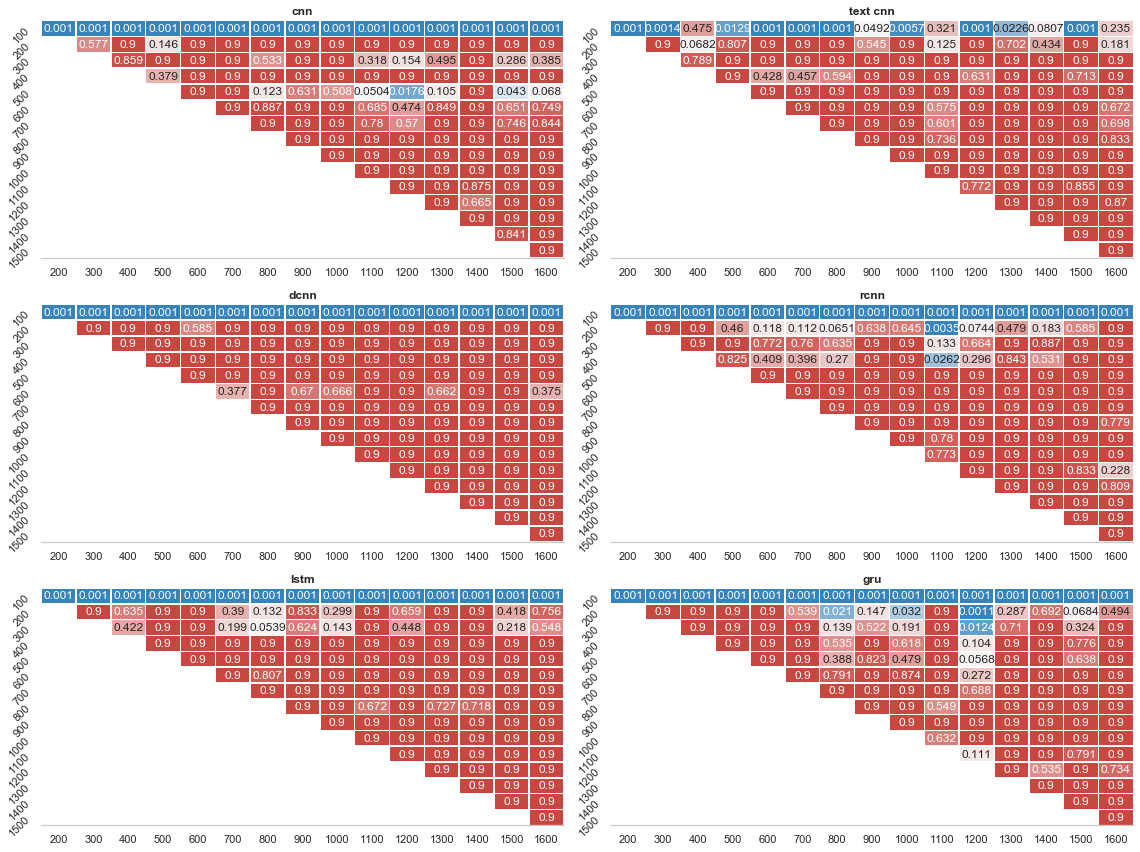

In [5]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 1000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 1000) | (tukey_frame.group2 > 1000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded, with a <pad> token, or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [6]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
53        gru              30  58.677818     0.254389
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_micro  f1_micro_std
54        gru              25  60.872844      0.415885  0.608798      0.004192


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,25,57.49,0.26,35,59.48,0.51,0.5954,0.0054
1,text cnn,40,56.40,0.33,15,59.27,0.46,0.5929,0.0045
2,dcnn,25,56.14,0.24,20,59.28,0.44,0.5932,0.0044
3,rcnn,25,58.13,0.26,25,60.21,0.64,0.6026,0.0065
4,lstm,10,57.98,0.26,50,60.18,0.66,0.6024,0.0068
5,gru,30,58.68,0.25,25,60.87,0.42,0.6088,0.0042


Plot accuracy of each model per sequence length.

Vertical lines are the cumulative frequency of utterances up to a given sequence length
i.e. there are 17550 sentences in the test set of length <= 10.

   max_seq_length    mean_freq  cum_sum
0             5.0  2663.600000  13318.0
1            10.0   932.000000  17550.0
2            15.0   414.833333  19494.0
3            20.0   182.166667  20324.0
4            25.0    83.833333  20712.0
5            30.0    39.000000  20881.0
6            35.0    18.833333  20971.0
7            40.0     8.833333  21010.0
8            45.0     4.000000  21028.0
9            50.0     3.200000  21041.0
Total sentence count: 21052
Percentage of sentences for sequence length 15: 92.6


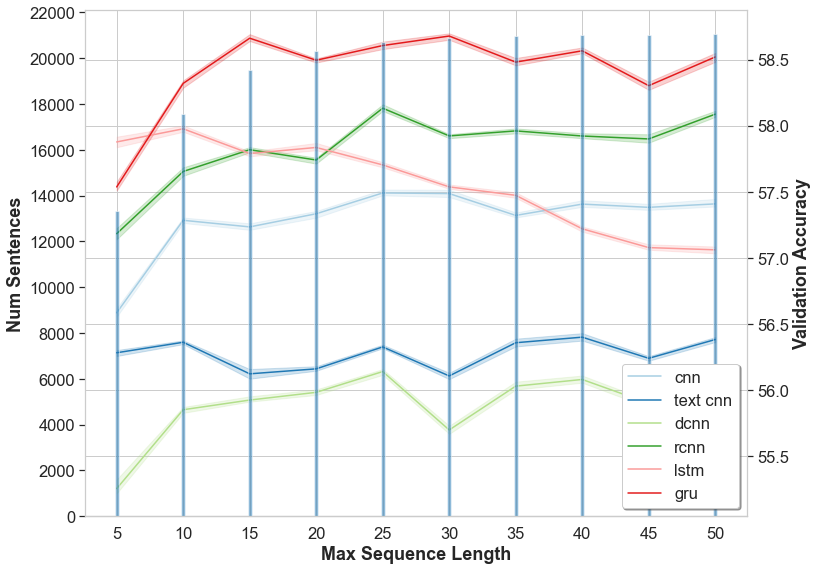

In [7]:
# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_len_count = collections.Counter(sent_lengths)
sent_len_count = pd.DataFrame.from_dict(dict(sorted(sent_len_count.items())), orient='index')

# Get word sentence lengths and bin/sum into same values as experiment
sents_frame = pd.DataFrame(columns=['max_seq_length', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 5
for i in range(10):
    sents_frame = sents_frame.append({'max_seq_length': ind_end,
                        'mean_freq': float(sent_len_count.loc[ind_start:ind_end].mean()), # Binning
                        'cum_sum': float(sent_len_count.loc[0:ind_end].sum())}, # Cumulative summing
                       ignore_index=True)
    ind_start += 5
    ind_end += 5
print(sents_frame)

# Calculate percentage of sentences up to specified max length
seq_len = 15
total_sent = int(sent_len_count.sum())
sent_cum_sum = float(sents_frame.loc[(sents_frame['max_seq_length'] == seq_len)]['cum_sum'])
perc_of_total = (100 / total_sent) * sent_cum_sum
print("Total sentence count: " + str(total_sent))
print("Percentage of sentences for sequence length " + str(seq_len) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sents_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='cum_sum', bar_axis_step=2000, bar_axis_range=None, bar_width=0.3,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different sequence length groups.

In [8]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

The following max_seq_length are not normally distributed.
  model_name max_seq_length    t-stat   p-value
3        cnn             20  0.829943  0.033408
All models max_seq_length have equal variance.
The following models do not have significant p-values when comparing max_seq_length groups.
            sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq   cohen_f      n       exp_n     power  exp_power
text cnn  1.098586  9.0  0.122065  1.888433  0.063634  0.158846  0.074039  0.169959  100.0  100.837023  0.795544        0.8


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq,cohen_f,n,exp_n,power,exp_power
cnn,6.179184,9.0,0.686576,9.808368,2.523847e-10,0.495163,0.442199,0.882753,100.0,27.406725,1.000000,0.8
text cnn,1.098586,9.0,0.122065,1.888433,6.363373e-02,0.158846,0.074039,0.169959,100.0,100.837023,0.795544,0.8
dcnn,5.687238,9.0,0.631915,6.654660,3.031313e-07,0.399567,0.337274,0.598919,100.0,35.499683,0.999967,0.8
rcnn,6.533938,9.0,0.725993,9.406410,5.912354e-10,0.484706,0.430711,0.846577,100.0,28.128400,1.000000,0.8
lstm,10.263817,9.0,1.140424,16.754101,7.418779e-16,0.626226,0.586413,1.400000,100.0,21.273918,1.000000,0.8
gru,10.029829,9.0,1.114425,12.995463,4.772937e-13,0.565132,0.519136,1.169592,100.0,23.309701,1.000000,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

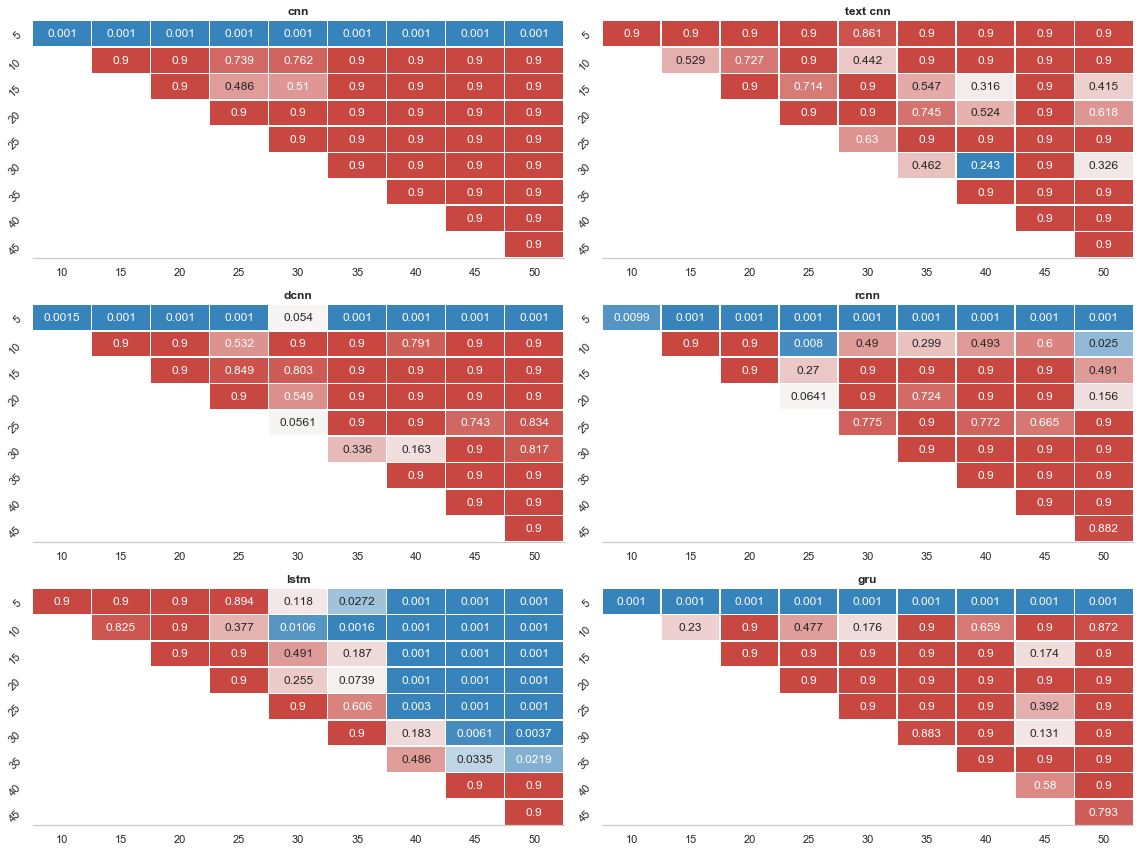

In [9]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Input Sequence Comparison

Compare a combination of vocabulary sizes (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens)
in small, medium and large groups.

In [10]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))


# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  vocab_size  max_seq_length    val_acc  val_acc_std
16        gru         800              50  58.587316     0.314054
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length  test_acc  test_acc_std  f1_micro  f1_micro_std
16        gru         800              50  60.67816      0.520228  0.606915      0.005397


,model_name,vocab_size,max_seq_length,val_acc,val_acc_std,vocab_size,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,400,25,57.72,0.23,1700,115,59.29,0.53,0.5935,0.0050
1,text cnn,1700,115,56.33,0.28,800,50,59.20,0.41,0.5923,0.0039
2,dcnn,800,50,56.11,0.26,1700,115,58.86,0.54,0.5894,0.0052
3,rcnn,1700,115,58.05,0.23,1700,115,59.85,0.57,0.5987,0.0058
4,lstm,400,25,57.47,0.25,800,50,59.90,0.78,0.5997,0.0074
5,gru,800,50,58.59,0.31,800,50,60.68,0.52,0.6069,0.0054


Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA comparing vocabulary size (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens) for each model.

NOTE:
- t-test comparing 'V=400_S=25' and 'V=1.7k_S=115' only cnn, rcnn and lstm show significant difference.
- t-test comparing 'V=800_S=50' and 'V=1.7k_S=115' only dcnn and lstm show significant difference.

In [11]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 400) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 800) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 1700) & (inseq_data['max_seq_length'] == 115)]
choices = ['V=400_S=25', 'V=800_S=50', 'V=1.7k_S=115']
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(inseq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(inseq_data, exp_param, metric)

All models exp_params are normally distributed.
The following models exp_params do not have equal variance.
  model_name  exp_params    t-stat   p-value
4       lstm         NaN  5.547946  0.009584
The following models do not have significant p-values when comparing exp_params groups.
            sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq   cohen_f     n       exp_n     power  exp_power
text cnn  0.039417  2.0  0.019709  0.369551  0.694486  0.026645 -0.043874  0.024637  30.0  394.081032  0.103261        0.8
rcnn      0.329553  2.0  0.164776  2.978368  0.067790  0.180744  0.116523  0.198558  30.0   51.640162  0.530861        0.8
gru       0.395336  2.0  0.197668  2.420182  0.107946  0.152020  0.086490  0.161345  30.0   62.809065  0.445309        0.8


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq,cohen_f,n,exp_n,power,exp_power
cnn,0.538149,2.0,0.269074,4.282784,2.423870e-02,0.240839,0.179556,0.285519,30.0,36.911552,0.697099,0.8
text cnn,0.039417,2.0,0.019709,0.369551,6.944862e-01,0.026645,-0.043874,0.024637,30.0,394.081032,0.103261,0.8
dcnn,0.548540,2.0,0.274270,4.085843,2.817103e-02,0.232337,0.170622,0.272390,30.0,38.530591,0.675213,0.8
rcnn,0.329553,2.0,0.164776,2.978368,6.778978e-02,0.180744,0.116523,0.198558,30.0,51.640162,0.530861,0.8
lstm,16.328238,2.0,8.164119,115.129413,6.073122e-14,0.895047,0.883837,1.400000,30.0,10.531607,0.999924,0.8
gru,0.395336,2.0,0.197668,2.420182,1.079463e-01,0.152020,0.086490,0.161345,30.0,62.809065,0.445309,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

,model_name,vocab_size,max_seq_length,val_acc,val_acc_std
0,cnn,400,25,57.715008,0.229754
1,cnn,800,50,57.435096,0.245091
2,cnn,1700,115,57.426866,0.274998
3,text cnn,400,25,56.242147,0.221423
4,text cnn,800,50,56.301943,0.185893
5,text cnn,1700,115,56.328886,0.276422
6,dcnn,800,50,56.105340,0.263390
7,dcnn,400,25,55.974042,0.226531
8,dcnn,1700,115,55.776344,0.284061
9,rcnn,400,25,57.794118,0.251065


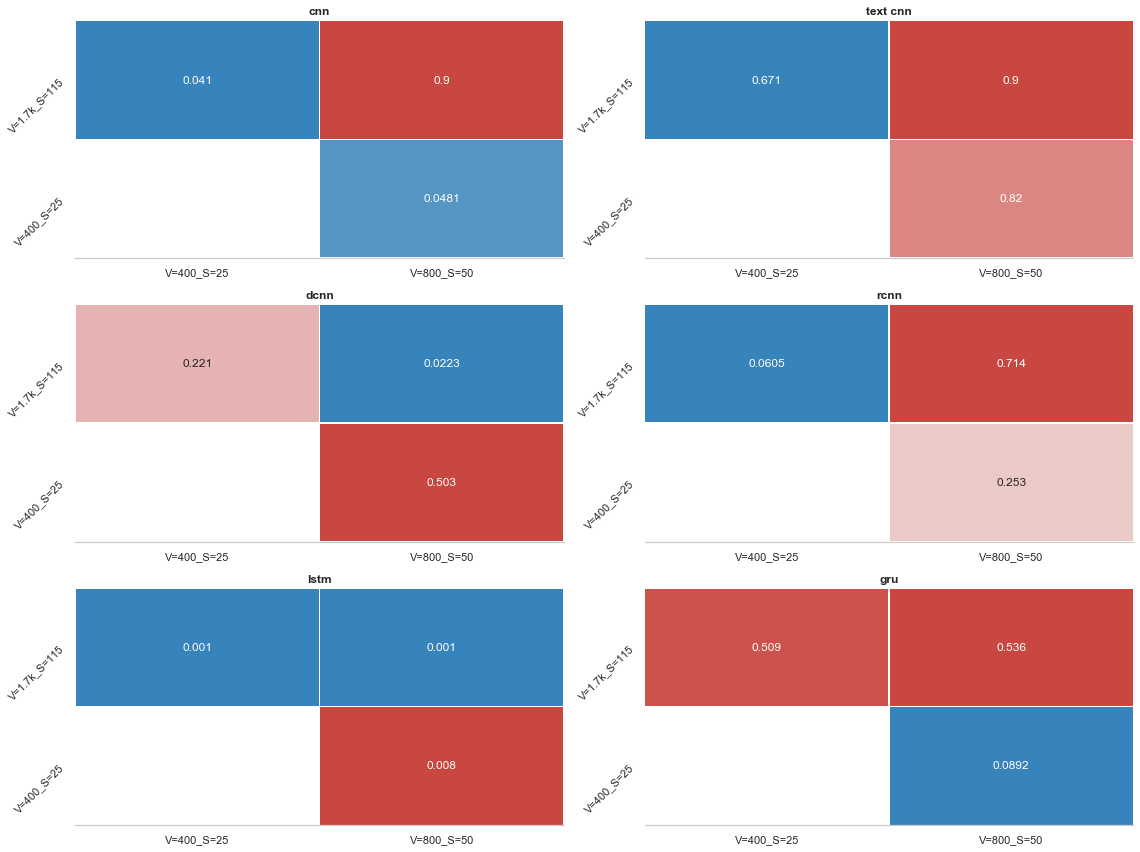

In [12]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param , exp_param + '_anova.png'))

# Show results for each group
inseq_mean_data = inseq_mean_data.drop(inseq_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std', 'vocab_size', 'max_seq_length']), axis=1)
inseq_mean_data

# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in the range [100, 300].

Get the embedding type and dimension corresponding to max validation and test accuracy per model.

In [13]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

Best validation accuracy in mean data:
    model_name embedding_type  embedding_dim    val_acc  val_acc_std
128        gru           deps            200  59.462143      0.23394
Best test accuracy in mean data:
   model_name embedding_type  embedding_dim  test_acc  test_acc_std  f1_micro  f1_micro_std
49   text cnn       word2vec            300   61.7227      0.411471  0.617524      0.003974


,model_name,embedding_type,embedding_dim,val_acc,val_acc_std,embedding_type,embedding_dim,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,fasttext,300,57.88,0.20,fasttext,150,59.53,0.74,0.5960,0.0069
1,text cnn,fasttext,300,58.97,0.24,word2vec,300,61.72,0.41,0.6175,0.0040
2,dcnn,fasttext,250,57.37,0.31,numberbatch,300,59.71,0.65,0.5975,0.0063
3,rcnn,deps,100,59.45,0.24,word2vec,200,61.01,0.44,0.6106,0.0044
4,lstm,glove,300,57.93,0.28,glove,300,60.41,0.58,0.6048,0.0058
5,gru,deps,200,59.46,0.23,numberbatch,200,61.62,0.49,0.6164,0.0050


Heatmap plot of accuracy of each model per embedding type and dimension.

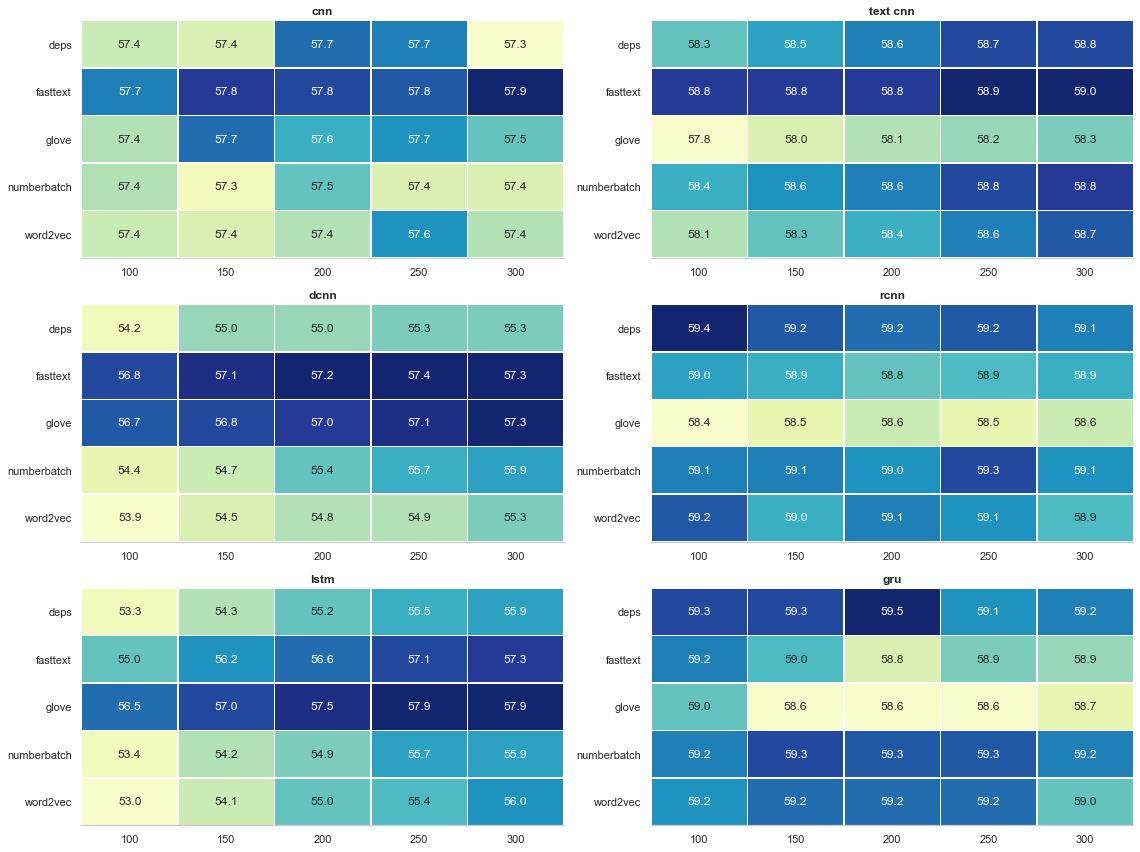

In [14]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name',
                        kind='heatmap', title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform Two-way ANOVA for each model, comparing different embedding type and dimension groups.

In [15]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Levene test for equal variance
levene_test(embed_data, 'embedding_params', metric)

# Run Two-way ANOVA
two_way_anova_test(embed_data, 'embedding_dim', 'embedding_type', metric, show_result=True)

The following embedding_params are not normally distributed.
    model_name embedding_params    t-stat   p-value
0          cnn        glove_100  0.724160  0.001730
46    text cnn         deps_100  0.835564  0.039036
80        rcnn     word2vec_200  0.759798  0.004697
91        rcnn     word2vec_300  0.791048  0.011284
93        rcnn        glove_150  0.840905  0.045239
106       lstm  numberbatch_250  0.815921  0.022620
121       lstm     fasttext_150  0.831388  0.034773
128        gru  numberbatch_200  0.844072  0.049363
136        gru         deps_250  0.803581  0.016026
143        gru  numberbatch_100  0.812123  0.020346
145        gru     word2vec_200  0.749421  0.003511
The following models embedding_params do not have equal variance.
  model_name  embedding_params    t-stat   p-value
1   text cnn               NaN  1.602996  0.041665
The following models do not have significant p-values when comparing embedding_dim and embedding_type groups.
   model_name                        

,model_name,exp_params,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
0,cnn,C(embedding_dim),0.800259,4.0,0.200065,2.584365,3.794887e-02,0.032745,0.020011
1,cnn,C(embedding_type),4.315420,4.0,1.078855,13.936256,3.576774e-10,0.176581,0.163393
2,cnn,C(embedding_dim):C(embedding_type),1.905054,16.0,0.119066,1.538050,8.800104e-02,0.077952,0.027184
3,text cnn,C(embedding_dim),5.461606,4.0,1.365402,29.794990,6.819204e-20,0.165088,0.159327
4,text cnn,C(embedding_type),16.612361,4.0,4.153090,90.626288,9.002979e-46,0.502143,0.495915
5,text cnn,C(embedding_dim):C(embedding_type),0.698005,16.0,0.043625,0.951965,5.106897e-01,0.021099,-0.001063
6,dcnn,C(embedding_dim),32.270524,4.0,8.067631,50.741885,2.099171e-30,0.091796,0.089946
7,dcnn,C(embedding_type),276.334534,4.0,69.083633,434.505962,1.475799e-104,0.786055,0.783891
8,dcnn,C(embedding_dim):C(embedding_type),7.167647,16.0,0.447978,2.817586,3.509542e-04,0.020389,0.013147
9,rcnn,C(embedding_dim),0.340741,4.0,0.085185,1.109144,3.530060e-01,0.009948,0.000977


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

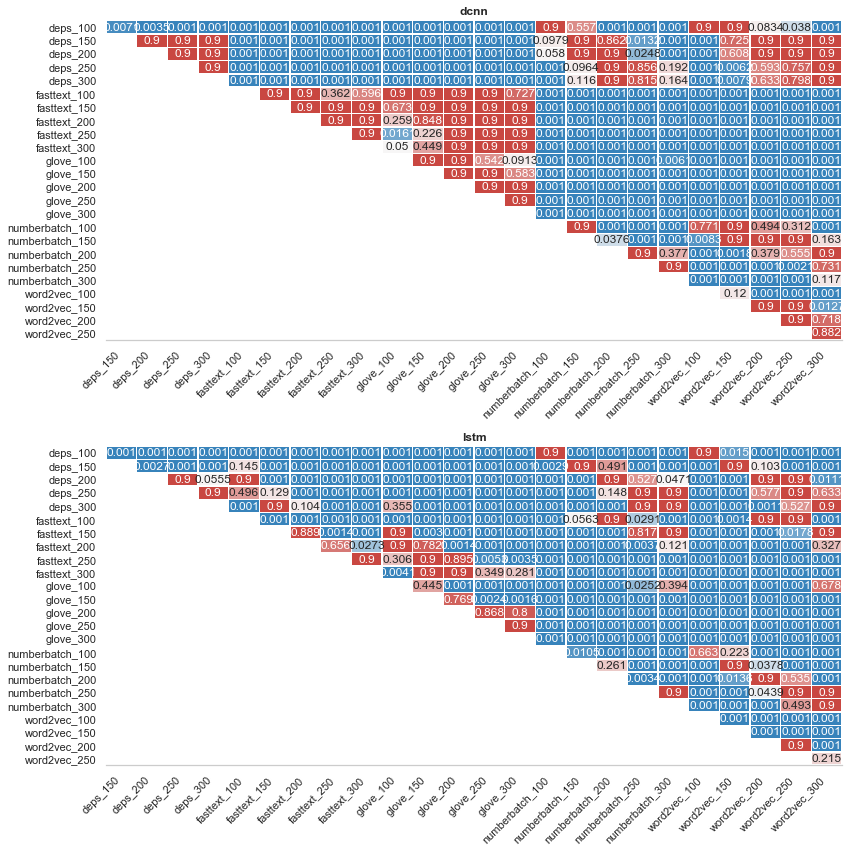

In [16]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(embed_data, 'embedding_params', metric, show_result=False)

# Just get the models where there is a significant difference
tukey_frame = tukey_frame.loc[(tukey_frame['model_name'] == 'dcnn') | (tukey_frame['model_name'] == 'lstm')]

# Generate heatmap
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=1, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=0, x_tick_rotation=45)
# g.savefig(os.path.join(task_name, 'embedding_type' ,'embedding_type_anova.png'))

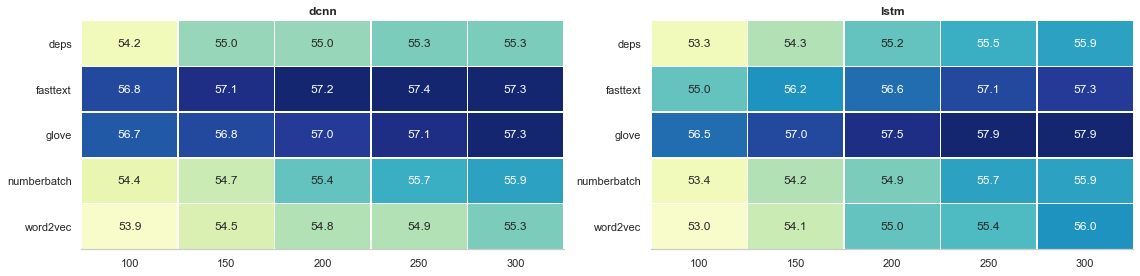

In [17]:
# Get only models that show significant effect
heatmap_data = embed_acc_data.loc[(embed_acc_data['model_name'] == 'dcnn') | (embed_acc_data['model_name'] == 'lstm')]

# Generate accuracy heatmap
g, fig = plot_facetgrid(heatmap_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name',
                        kind='heatmap', title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_dcnn_accuracy.png'))

# Input sequence and embeddings final results

Results for the 6 base models using the parameters (vocabulary size, sequence length and embeddings) from previous experiments.

In [18]:
# Name of the experiment parameter for comparison
exp_param = 'input_seq_final'

# Load language models experiment data
inseq_final_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
inseq_final_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_final_data_max = get_max(inseq_final_mean_data, [])
inseq_final_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
3       rcnn  58.731445     0.202454
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_micro  f1_micro_std
5        gru  61.121407      0.638604  0.611224      0.006715


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,57.58,0.24,59.22,1.01,0.5928,0.0101
1,text cnn,58.54,0.24,60.24,0.63,0.6027,0.0065
2,dcnn,57.73,0.39,59.96,0.58,0.5998,0.0057
3,rcnn,58.73,0.20,60.43,0.62,0.6045,0.0061
4,lstm,58.15,0.15,59.86,0.62,0.5990,0.0063
5,gru,58.49,0.36,61.12,0.64,0.6112,0.0067


# Model variants results

Results and comparison for the bi-directional and multi-layer for recurrent models.
Results and comparison for the attentional variants of all 6 base models.

In [19]:
# Name of the experiment parameter for comparison
exp_param = 'model_variants'

# Load language models experiment data
variants_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
variants_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Remove CRF because they are strictly worse
variants_data = variants_data[~variants_data['model_name'].str.contains('crf')]
variants_mean_data = variants_mean_data[~variants_mean_data['model_name'].str.contains('crf')]

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
variants_data_max = get_max(variants_mean_data, [])
variants_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

Best validation accuracy in mean data:
       model_name    val_acc  val_acc_std
13  text cnn attn  58.550391     0.301326
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_micro  f1_micro_std
0     bi gru  61.165229      0.693715  0.611984      0.006678


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bi gru,58.51,0.44,61.17,0.69,0.6120,0.0067
1,bi lstm,57.94,0.17,59.73,0.62,0.5981,0.0061
2,cnn attn,58.03,0.21,59.68,0.36,0.5975,0.0037
3,dcnn attn,57.47,0.23,59.96,0.35,0.5996,0.0032
4,deep gru 2lyr,57.96,0.35,60.04,0.64,0.6006,0.0065
5,deep gru 3lyr,57.48,0.28,59.17,1.01,0.5922,0.0094
6,deep lstm 2lyr,58.32,0.17,59.94,0.68,0.6001,0.0065
7,deep lstm 3lyr,58.10,0.24,60.02,0.70,0.6008,0.0065
8,gru attn,58.43,0.15,60.59,0.47,0.6065,0.0048
9,lstm attn,58.09,0.20,59.91,0.47,0.5993,0.0048


Merge base and variant results

In [20]:
# Merge all of the supervised models results
final_data = pd.concat([inseq_final_data, variants_data], ignore_index=True)
final_data.drop('index', axis=1, inplace=True)

final_mean_data = pd.concat([inseq_final_mean_data, variants_mean_data], ignore_index=True)
final_mean_data.drop('index', axis=1, inplace=True)
final_mean_data = final_mean_data.drop(final_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std',
                                                                           'test_acc', 'test_acc_std', 'f1_micro',
                                                                           'f1_micro_std']), axis=1)

metric = 'val_acc'

### Multi-layer

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).
Run ANOVA between recurrent models and their multi layer (2 and 3 layers) variants.

In [21]:
# Get only the recurrent models and variants
deep_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]
deep_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]

deep_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]
deep_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]

print("LSTM Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_lstm_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(deep_lstm_data, 'model_name', metric)

# Run ANOVA
bi_lstm_anova = one_way_anova_test(deep_lstm_data, 'model_name', metric)
print(bi_lstm_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_lstm_data, 'model_name', metric)

print("GRU Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_gru_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(deep_gru_data, 'model_name', metric)

# Run ANOVA
bi_gru_anova = one_way_anova_test(deep_gru_data, 'model_name', metric)
print(bi_gru_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_gru_data, 'model_name', metric)

# Show multi-layer results
deep_recurrent_data = pd.concat([deep_lstm_mean_data, deep_gru_mean_data], ignore_index=True)
deep_recurrent_data = deep_recurrent_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']]
deep_recurrent_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

LSTM Variants
All models model_name are normally distributed.
All models have equal variance. P-value = 0.24269
The models have significant p-values when comparing groups. P-value = 0.0365
                 sum_sq    df   mean_sq         F    PR(>F)    eta_sq  omega_sq   cohen_f   n      exp_n     power  exp_power
C(model_name)  0.268744   2.0  0.134372  3.751528  0.036503  0.217461  0.155002  0.250102  30  41.669886  0.635431        0.8
Residual       0.967085  27.0  0.035818       NaN       NaN       NaN       NaN  0.250102  30  41.669886  0.635431        0.8
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
deep lstm 2lyr deep lstm 3lyr  -0.2225  0.036 -0.4323 -0.0127   True
deep lstm 2lyr           lstm  -0.1676 0.1364 -0.3774  0.0422  False
deep lstm 3lyr           lstm   0.0549 0.7797 -0.1549  0.2648  False
-------------------

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,lstm,58.15,0.15,59.86,0.62,0.5990,0.0063
1,deep lstm 2lyr,58.32,0.17,59.94,0.68,0.6001,0.0065
2,deep lstm 3lyr,58.10,0.24,60.02,0.70,0.6008,0.0065
3,gru,58.49,0.36,61.12,0.64,0.6112,0.0067
4,deep gru 2lyr,57.96,0.35,60.04,0.64,0.6006,0.0065
5,deep gru 3lyr,57.48,0.28,59.17,1.01,0.5922,0.0094


### Bi-directional

Run t-test comparing base recurrent models and their bi-directional variants.

In [22]:
# Get only base and bi-directional models
bi_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]
bi_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]

bi_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]
bi_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]

# Show bi-directional results
bi_directional_data = pd.concat([bi_lstm_mean_data, bi_gru_mean_data], ignore_index=True)
bi_directional_data = bi_directional_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']]
bi_directional_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,lstm,58.15,0.15,59.86,0.62,0.5990,0.0063
1,bi lstm,57.94,0.17,59.73,0.62,0.5981,0.0061
2,gru,58.49,0.36,61.12,0.64,0.6112,0.0067
3,bi gru,58.51,0.44,61.17,0.69,0.6120,0.0067


In [23]:
print("LSTM Bi-directional Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(bi_lstm_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(bi_lstm_data, 'model_name', metric)

# Select the data to compare
data_a = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'lstm')][metric]
data_b = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'bi lstm')][metric]

# Perform power analysis
effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

# T-test
t, p = ttest_ind(data_a, data_b)
print("t-stat = " + str(t.round(5)) + " p-value = " + str(p.round(5)) + " cohen-d = " +  str(effect.round(5)) + " n = "
      + str(len(data_a)) + " exp_n = " +  str(int(exp_n)) +  " power = " + str(act_power.round(5)) +  " exp_power = " + str(0.8))

print("GRU Bi-directional Variants")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(bi_gru_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(bi_gru_data, 'model_name', metric)

# Select the data to compare
data_a = bi_gru_data.loc[(bi_gru_data['model_name'] == 'gru')][metric]
data_b = bi_gru_data.loc[(bi_gru_data['model_name'] == 'bi gru')][metric]

# Perform power analysis
effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

# T-test
t, p = ttest_ind(data_a, data_b)
print("t-stat = " + str(t.round(5)) + " p-value = " + str(p.round(5)) + " cohen-d = " +  str(effect.round(5)) + " n = "
      + str(len(data_a)) + " exp_n = " +  str(int(exp_n)) +  " power = " + str(act_power.round(5)) +  " exp_power = " + str(0.8))

LSTM Bi-directional Variants
All models model_name are normally distributed.
All models have equal variance. P-value = 0.76557
t-stat = 2.90737 p-value = 0.00939 cohen-d = 1.30021 n = 10 exp_n = 10 power = 0.78508 exp_power = 0.8
GRU Bi-directional Variants
All models model_name are normally distributed.
All models have equal variance. P-value = 0.33334
t-stat = -0.09098 p-value = 0.92852 cohen-d = -0.04069 n = 10 exp_n = 9484 power = 0.05085 exp_power = 0.8


### Attention

Run t-test comparing base models and their attentional variants.

In [24]:
# Get only base and attentional models
attn_data = final_data[~final_data.model_name.str.contains('bi|deep|crf')]
attn_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('bi|deep|crf')]

# Show attentional results
attn_mean_data = attn_mean_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']]
attn_mean_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,57.58,0.24,59.22,1.01,0.5928,0.0101
1,text cnn,58.54,0.24,60.24,0.63,0.6027,0.0065
2,dcnn,57.73,0.39,59.96,0.58,0.5998,0.0057
3,rcnn,58.73,0.20,60.43,0.62,0.6045,0.0061
4,lstm,58.15,0.15,59.86,0.62,0.5990,0.0063
5,gru,58.49,0.36,61.12,0.64,0.6112,0.0067
8,cnn attn,58.03,0.21,59.68,0.36,0.5975,0.0037
9,dcnn attn,57.47,0.23,59.96,0.35,0.5996,0.0032
14,gru attn,58.43,0.15,60.59,0.47,0.6065,0.0048
15,lstm attn,58.09,0.20,59.91,0.47,0.5993,0.0048


In [25]:
# Create results frame
attn_t_test_frame = pd.DataFrame(columns=['model_name', 't-stat', 'p-value'])

# Perform t-test for each model and its attn variant
for model in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:

    current_attn_data = attn_data.loc[(attn_data['model_name'] == model) | (attn_data['model_name'] == model + ' attn')]

    # Run Shaprio-wilks test for normal distribution
    shapiro_wilk_test(current_attn_data, 'model_name', metric)

    # Run Levene test for equal variance
    levene_test(current_attn_data, 'model_name', metric)

    # Select the data to compare
    data_a = attn_data.loc[(attn_data['model_name'] == model)][metric]
    data_b = attn_data.loc[(attn_data['model_name'] == model + ' attn')][metric]

    # Perform power analysis
    effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

    # T-test
    t, p = ttest_ind(data_a, data_b)

    # Append to result frame
    attn_t_test_frame = attn_t_test_frame.append({'model_name': model, 't-stat': t, 'p-value': p, 'cohen-d': effect,
                                                  'n': len(data_a), 'exp_n': exp_n, 'power': act_power, 'exp_power': 0.8},
                                                 ignore_index=True)


if all(p_value <= 0.05 for p_value in attn_t_test_frame['p-value']):
    print("All models have significant p-values when comparing attention groups.")
else:
    print("The following models do not have significant p-values when comparing attention groups.")
    print(attn_t_test_frame.loc[attn_t_test_frame['p-value'] > 0.05])

attn_t_test_frame.round(5)

All models model_name are normally distributed.
All models have equal variance. P-value = 0.81296
All models model_name are normally distributed.
All models have equal variance. P-value = 0.47577
All models model_name are normally distributed.
All models have equal variance. P-value = 0.183
All models model_name are normally distributed.
All models have equal variance. P-value = 0.81713
All models model_name are normally distributed.
All models have equal variance. P-value = 0.44826
All models model_name are normally distributed.
Some models do not have equal variance. ['gru' 'gru attn'] P-value = 0.02439
The following models do not have significant p-values when comparing attention groups.
  model_name    t-stat   p-value   cohen-d        exp_n  exp_power     n     power
1   text cnn -0.098425  0.922683 -0.044017  8103.079631        0.8  10.0  0.050998
2       dcnn  1.764356  0.094635  0.789044    26.209474        0.8  10.0  0.386195
4       lstm  0.788766  0.440514  0.352747   127.12

,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,cnn,-4.57239,0.00024,-2.04483,4.92747,0.8,10.0,0.99079
1,text cnn,-0.09842,0.92268,-0.04402,8103.07963,0.8,10.0,0.05100
2,dcnn,1.76436,0.09464,0.78904,26.20947,0.8,10.0,0.38619
3,rcnn,2.11026,0.04909,0.94374,18.63621,0.8,10.0,0.51487
4,lstm,0.78877,0.44051,0.35275,127.12408,0.8,10.0,0.11604
5,gru,0.50544,0.61939,0.22604,308.19991,0.8,10.0,0.07667


# Language Models

Using pre-trained language models to generate sequence representations.

In [26]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_micro' :f1_round_val, 'f1_micro_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name   val_acc  val_acc_std
4      xlnet  61.20519     0.508708
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_micro  f1_micro_std
0       bert  62.907314      0.324844  0.629001      0.003265


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_micro,f1_micro_std
0,bert,61.12,0.44,62.91,0.32,0.6290,0.0033
1,roberta,61.18,0.40,62.63,0.24,0.6263,0.0024
2,gpt2,60.18,0.28,61.04,0.98,0.6105,0.0099
3,dialogpt,57.04,1.83,56.70,1.85,0.5669,0.0184
4,xlnet,61.21,0.51,61.61,0.78,0.6161,0.0078
5,convert,58.16,0.21,60.94,0.63,0.6094,0.0063
6,elmo,58.34,0.21,60.44,0.35,0.6046,0.0035
7,use,59.35,0.22,60.67,0.56,0.6068,0.0055
8,mlstm char lm,58.50,0.27,60.79,0.63,0.6079,0.0063
9,nnlm,52.44,0.18,56.65,0.24,0.5670,0.0024


Plot accuracy of each language model.

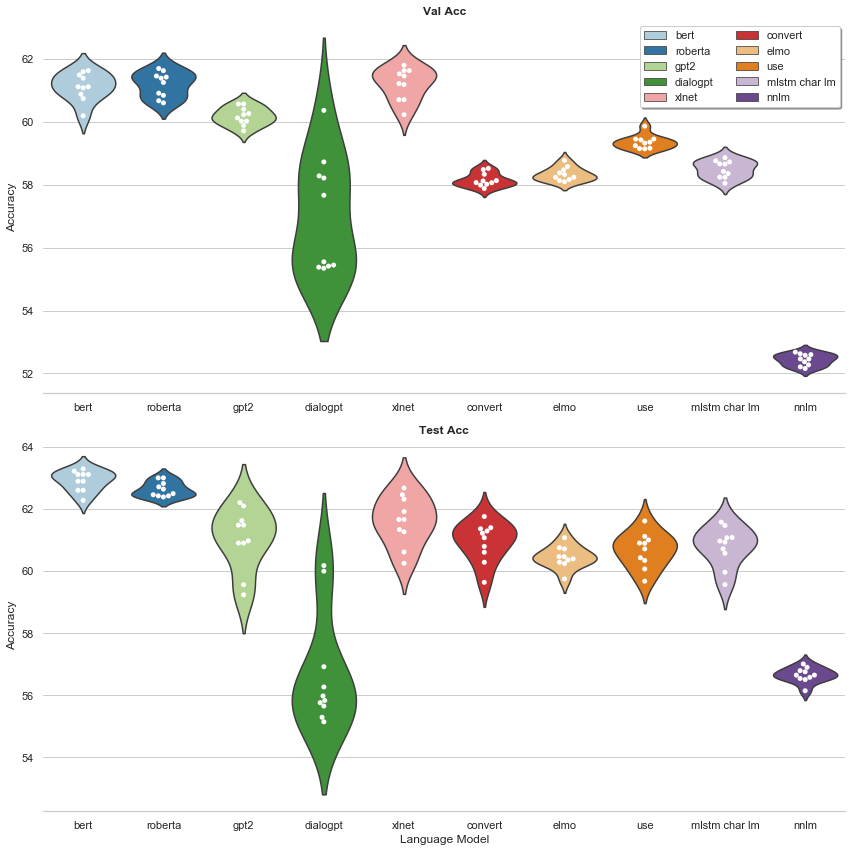

In [27]:
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)
g.savefig(os.path.join(task_name, 'language_models', 'language_models' + '_accuracy.png'))

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Run t-tests to compare each language models with the best supervised model.

In [29]:
# Set the metric to test
metric = 'test_acc'

# Get the best supervised model
best_super = final_data.loc[(final_data['model_name'] == 'bi gru')]

# Get the top 5 language models
best_lm = lm_data[lm_data.model_name.str.contains('bert|roberta|gpt2|dialogpt|xlnet')]

# Create results frame
t_test_frame = pd.DataFrame(columns=['model_name', 't-stat', 'p-value'])

# Perform t-test for each language model and the supervised
for model_name in (lm_data['model_name'].unique()):

    # Select the current lm
    current_lm = lm_data.loc[(lm_data['model_name'] == model_name)]

    # Run Levene test for equal variance
    levene_test(pd.concat([current_lm, best_super]), 'model_name', metric)

    # Select the data to compare
    data_a = current_lm[metric]
    data_b = best_super[metric]

    # Perform power analysis
    effect, exp_n, act_power = t_test_power_analysis(data_a, data_b, alpha=0.05, power=0.8)

    # T-test
    t, p = ttest_ind(data_a, data_b)

    # Append to result frame
    t_test_frame = t_test_frame.append({'model_name': model_name, 't-stat': t, 'p-value': p, 'cohen-d': effect,
                                        'n': len(data_a), 'exp_n': exp_n, 'power': act_power, 'exp_power': 0.8},
                                       ignore_index=True)


if all(p_value <= 0.05 for p_value in t_test_frame['p-value']):
    print("All models have significant p-values when comparing with supervised.")
else:
    print("Some models do not have significant p-values when comparing with supervised.")
    print(t_test_frame.loc[t_test_frame['p-value'] > 0.05])

t_test_frame.round(5)

All models have equal variance. P-value = 0.10137
Some models do not have equal variance. ['roberta' 'bi gru'] P-value = 0.04605
All models have equal variance. P-value = 0.50986
All models have equal variance. P-value = 0.27223
All models have equal variance. P-value = 0.88391
All models have equal variance. P-value = 0.66443
All models have equal variance. P-value = 0.09818
All models have equal variance. P-value = 0.52701
All models have equal variance. P-value = 0.60035
Some models do not have equal variance. ['nnlm' 'bi gru'] P-value = 0.03405
Some models do not have significant p-values when comparing with supervised.
      model_name    t-stat   p-value   cohen-d    exp_n  exp_power     n     power
2           gpt2 -0.322128  0.751067 -0.144060  757.359        0.8  10.0  0.060745
4          xlnet  1.349898  0.193781  0.603693  44.0542        0.8  10.0  0.248379
5        convert -0.768086  0.452396 -0.343498  134.009        0.8  10.0  0.112540
7            use -1.749931  0.097158

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,model_name,t-stat,p-value,cohen-d,exp_n,exp_power,n,power
0,bert,7.19180,0.00000,3.21627,2.87162,0.8,10.0,1.00000
1,roberta,6.32332,0.00001,2.82787,3.26426,0.8,10.0,0.99997
2,gpt2,-0.32213,0.75107,-0.14406,757.359,0.8,10.0,0.06075
3,dialogpt,-7.14421,0.00000,-3.19499,2.88924,0.8,10.0,1.00000
4,xlnet,1.34990,0.19378,0.60369,44.0542,0.8,10.0,0.24838
5,convert,-0.76809,0.45240,-0.34350,134.009,0.8,10.0,0.11254
6,elmo,-2.92481,0.00905,-1.30801,10.2307,0.8,10.0,0.78985
7,use,-1.74993,0.09716,-0.78259,26.6263,0.8,10.0,0.38100
8,mlstm char lm,-1.27793,0.21751,-0.57151,49.0401,0.8,10.0,0.22752
9,nnlm,-19.46441,0.00000,-8.70475,[10.0],0.8,10.0,1.00000
